# Collect Runtime Statistics with `Watcher`

The `Watcher` module can collect runtime statistics. It uses
the observer pattern: once an `Watcher` is registered to an
`Algorithm`, events reported by the `Algorithm` may handlers 

This module is useful when the algorithm has a complicated `.step(..)`.
Otherwise, it is always possible to collect information by inspecting
the `Algorithm` in between iterations.

Running this tutorial requires `matplotlib`.

### Construct Algorithm

To begin, consider a simple GA with the following configuration:

| Component  | Guide                                          |
| ----------- | ---------------------------------------------- |
|`Individual`|Binary string|
|`Evaluator`|OneMax|
|`Selector`|Elitist truncation|
|`Variator`|Mutation|

Use a population size of 100 and individual size of 50 bits.
EvoKit has all building blocks for this algorithm; for convenience,
automate its creation with a function:

In [1]:
from evokit.core import Population
from evokit.evolvables.algorithms import SimpleLinearAlgorithm
from evokit.evolvables.selectors import TruncationSelector, Elitist
from evokit.evolvables.binstring import BinaryString, CountBits, MutateBits

IND_SIZE: int = 50
POP_SIZE: int = 100
MUTATE_P: float = 0.01

def make_algo() -> SimpleLinearAlgorithm[BinaryString]:
    pop: Population[BinaryString] = Population(
        BinaryString.random(IND_SIZE) for _ in range(POP_SIZE))
    return SimpleLinearAlgorithm(population=pop,
                                 variator=MutateBits(MUTATE_P),
                                 evaluator=CountBits(),
                                 selector=Elitist(TruncationSelector(POP_SIZE)))

ModuleNotFoundError: No module named 'evokit.accounting.watcher'

Because `CanonicalGeneticAlgorithm` has only one population,
this attribute can be accessed as `.population`. Operators of
this algorithm are not stateless and do not have much to offer
in terms of analytics.

In [ ]:
import matplotlib.pyplot as plt

## The Manual Approach

For a simple example, collect then plot the fitness curve by generation:

In [ ]:
STEP_COUNT: int = 30

algo = make_algo()
best_fitnesses: list[float] = []

for _ in range(STEP_COUNT):
    algo.step()
    best_fitnesses.append(algo.population.best().fitness[0])

Text(0, 0.5, 'Best fitness')

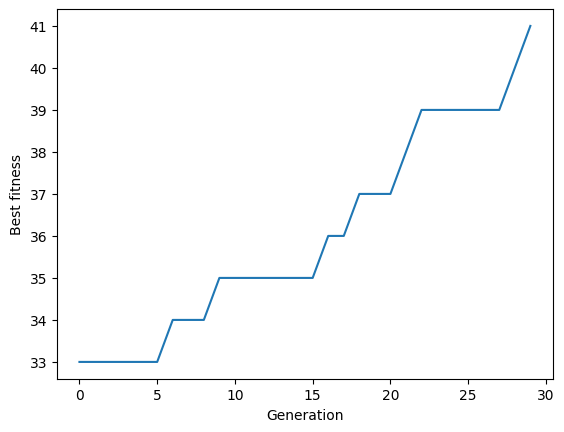

In [ ]:
plt.plot(range(STEP_COUNT), best_fitnesses)  #type: ignore[reportUnknownMemberType]
plt.xlabel("Generation")  #type: ignore[reportUnknownMemberType]
plt.ylabel("Best fitness")  #type: ignore[reportUnknownMemberType]

## Automating with Watcher

In `watching`, the `.Watcher` module automates statistics collection.
`watching.watchers` provides several simple watchers for reference.
In addition, `watching.visualisers` offers a suite of utilities
to plot collected data.

Instead of using a stock watcher, let's build our own!

### Inspecting Available Events

To create an watcher for an algorithm, it's best to check what
event the algorithm could report. An algorithm declares its standard
events in `.events`.
Furthermore, the base class `Algorithm` fires two events automatically:
`STEP_BEGIN` before `.step(..)` and `STEP_END` after. These events are
declared in `.automatic_events`.

Check which events the SimpleLinearAlgorithm could report:

In [ ]:
algo_2 = make_algo()
print(f"events: {algo_2.events}; automatic events: {algo_2.automatic_events}")

events: ['POST_VARIATION', 'POST_EVALUATION', 'POST_SELECTION']; automatic events: ['STEP_BEGIN', 'STEP_END']


### Crafting an Watcher
An watcher must be created with `accounting.Watcher`.
The constructor takes three parameters: (a) a list of `events`
that can trigger collection, (b) a callable `handler` that collects
data from the associated algorithm, and (c) an optional parameter
that controls if the watcher should also `watch_automatic_events`.

For simplicity, declare an `Watcher` that collects the best fitness
from a population only on automatic events. Observe the signature:
the watcher collects...

* ... from a `HomogeneousAlgorithm` (`Algorithm` with one `.population`)
of `BinaryString`s,
* a `tuple` of one `float` that contains a fitness value.

An algorithm can register several watchers, which are
updated in order or registration. To check if the watcher
is registered, check if it is in `Algorithm.watchers`.

In [ ]:
from evokit.watching import Watcher
from evokit.evolvables.algorithms import HomogeneousAlgorithm

In [ ]:
fit_acc = Watcher[HomogeneousAlgorithm[BinaryString], tuple[float, ...]](
    events=[],
    handler=lambda algo: algo.population.best().fitness,
    watch_automatic_events=True)

algo_2.register(fit_acc)
assert(fit_acc in algo_2.watchers)

To see how things work under the hood, fire an
event in the algorithm, then check what the watcher
has collected.

Each record contains four values: (a) the event that triggered
collection, (b) the generation in which the event is fired, the
time (via `time.perf_timer`, in seconds) at which the event in fired,
and (d) the collected value.

Not all statistics are available at all times: for example, because
the population starts off unevaluated, the best fitness is
`(nan,)`.

In [ ]:
algo_2.update(algo.automatic_events[0])
print(fit_acc.report())

[WatcherRecord(event='STEP_BEGIN', generation=0, value=(nan,), time=443313.1574931)]


Now, wipe all records from `fit_acc` and see how
it collects statistics from a running algorithm. Then, visualise
the results with a function from `accounting.visualisers`:

In [ ]:
fit_acc.purge()

for _ in range(STEP_COUNT):
    algo_2.step()

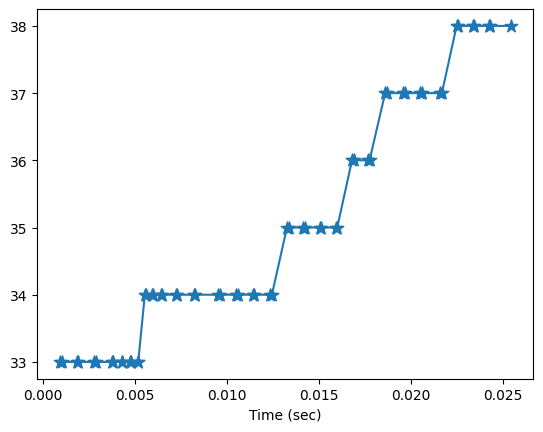

In [ ]:
from evokit.watching.visualisers import plot

plot(fit_acc.report(),
     track_generation=True,
     use_line=True,)

Notice that the visualiser highlights automatic events,
which mark boundaries of generations. It also plots data points
over runtime, which provides an intuitive view of training progression.